**Mask-RCNN Starter Model for the RSNA Pneumonia Detection Challenge with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon

This is a modified version of the starter model. I have made some minor changes to the Mask_RCNN in a fork but nothing that should cause errors. I have also increased the input image size to 448x448 and greatly increased the data augmentation.

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import keras
import glob 

Using TensorFlow backend.


In [2]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [3]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [4]:
DATA_DIR = '/home/eric/pneumonia'

# Directory to save logs and trained model
ROOT_DIR = '/home/eric/pneumonia/working'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [5]:
# !git clone https://www.github.com/escuccim/Mask_RCNN.git
os.chdir('Mask_RCNN')

In [6]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [7]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [8]:
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [9]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [10]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia384_2'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 10
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (48, 96, 192, 384)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 5
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1
    
    # make each epoch a full epoch instead of shorter ones
    STEPS_PER_EPOCH = 23482 // IMAGES_PER_GPU
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     10
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        5
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 10
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [11]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [12]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [13]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [14]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [15]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [16]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = int(len(image_fps_list) * .12)
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

23482 3202


### Create and prepare the training dataset using the DetectorDataset class.

In [17]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

# one dataset containing all images - we'll train on this for an epoch or two at the end
dataset_all = DetectorDataset(image_fps_list, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_all.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
/home/eric/pneumonia/stage_2_train_images/b54f130a-94fc-49ae-a6b2-5e1c870720a7.dcm
[1 1]


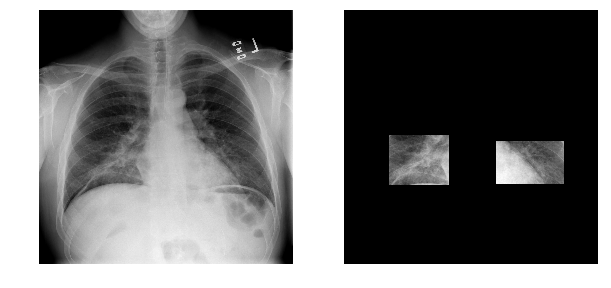

In [18]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
    
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation.

Three levels of augmentation with 3 being the least. It seems that the Gaussian blur and sharpen are the most CPU intensive, so we have removed those from ensuing levels.

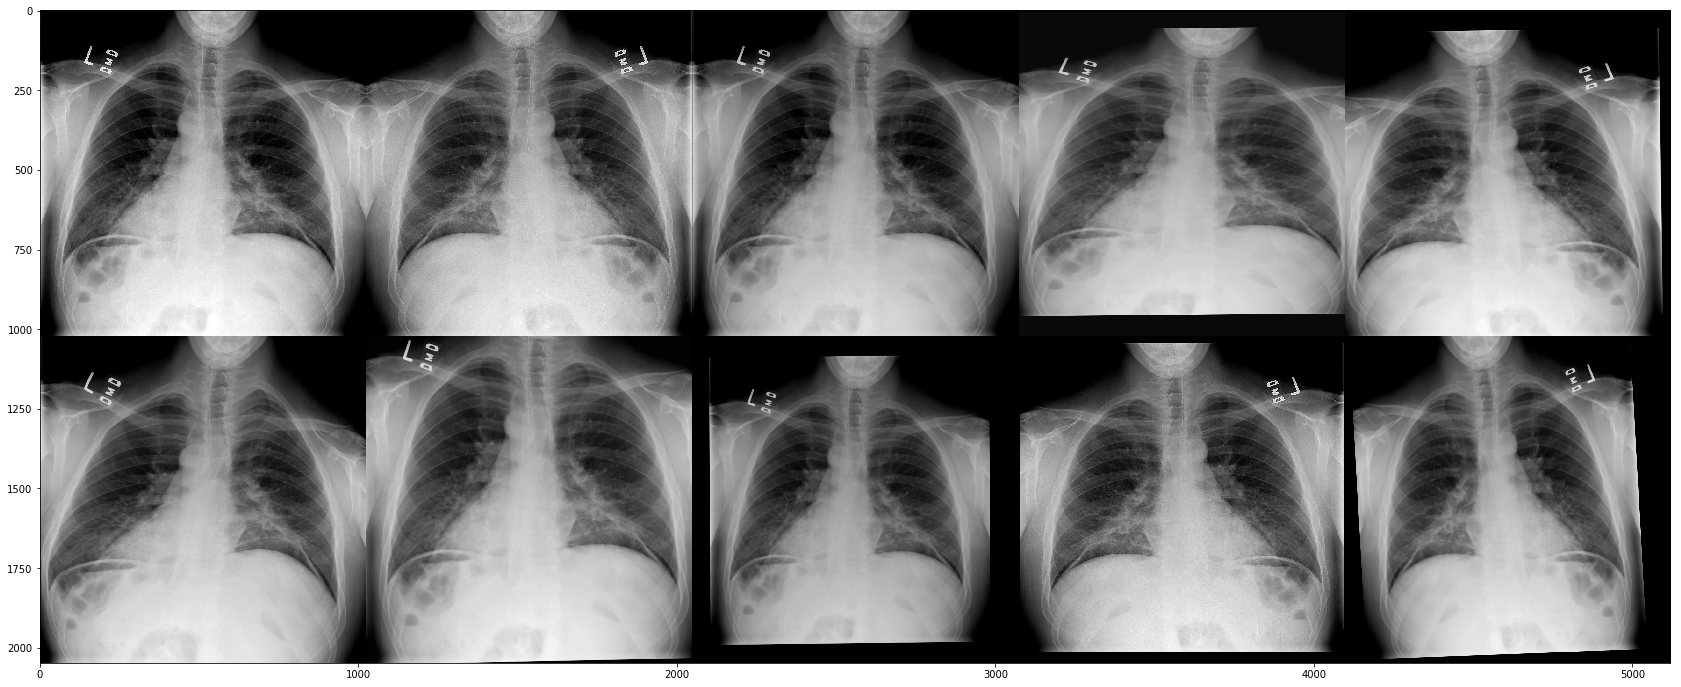

In [19]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Image augmentation (heavy and random)
augmentation = iaa.Sequential([
    # flip left/right 50% of time
    iaa.Fliplr(0.5),
    iaa.Sequential([
        iaa.OneOf([ ## geometric transform
            iaa.Affine(
                scale={"x": (0.85, 1.15), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.08, 0.08)},
                rotate=(-2.5, 2.5),
                shear=(-1.5, 1.5),
            ),
            iaa.PiecewiseAffine(scale=(0.005, 0.075)),
            iaa.Noop(),
        ]),
        iaa.OneOf([
            iaa.Crop(px=(0, 40)),
            iaa.Pad(px=(0, 40)),
            iaa.Noop(),
        ]),
    ], True),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.75, 1.25)),
        iaa.Add((-20, 20)),
        iaa.Noop(),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.4)),
        iaa.Sharpen(alpha=(0.0, 0.4)),
        iaa.Noop(),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [20]:
# Image augmentation (heavy and random)
augmentation2 = iaa.Sequential([
    # flip left/right 50% of time
    iaa.Fliplr(0.5),
    iaa.Sequential([
        iaa.OneOf([ ## geometric transform
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.85, 1.15)},
                translate_percent={"x": (-0.03, 0.03), "y": (-0.05, 0.05)},
                rotate=(-2, 2),
                shear=(-1, 1),
            ),
            iaa.PiecewiseAffine(scale=(0.003, 0.05)),
            iaa.Noop(),
        ]),
        iaa.OneOf([
            iaa.Crop(px=(0, 35)),
            iaa.Pad(px=(0, 35)),
            iaa.Noop(),
        ]),
    ], True),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.8, 1.2)),
        iaa.Add((-15, 15)),
        iaa.Noop(),
    ]),
])

# test on the same image as above
imggrid = augmentation2.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/eric/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-35ba91c332ea>", line 31, in <module>
    imggrid = augmentation2.draw_grid(image[:, :, 0], cols=5, rows=2)
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 769, in draw_grid
    augs.append(det.augment_images([image] * (rows * cols)))
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 1522, in _augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 1514, in _augment_images
    hook

KeyboardInterrupt: 

In [ ]:
# Less augmentation to speed up training
augmentation3 = iaa.Sequential([
    # flip left/right 50% of time
    iaa.Fliplr(0.5),
    
    # crop or pad the image
    iaa.OneOf([
        iaa.CropAndPad(px=(-20, 20)),
        iaa.OneOf([ ## geometric transform
                iaa.Affine(
                    scale={"x": (0.98, 1.02), "y": (0.95, 1.08)},
                    translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
                    rotate=(-2, 2),
                    shear=(-1, 1),
                ),
                iaa.PiecewiseAffine(scale=(0.001, 0.025)),
                iaa.Noop(),
            ]),
        ]),
    # blur or sharpen
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.95, 1.05)),
        iaa.ContrastNormalization((0.85, 1.15)),
        iaa.Add((-10, 10)),
        iaa.Noop(),
    ]),
], True)

# test on the same image as above
imggrid = augmentation3.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# try to load the latest checkpoint, if there is a problem initialize with the coco weights instead
try:    
    # find the most recent checkpoint
    checkpoint = model.find_last()
    checkpoint = "/home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0008.h5"
    print("Loading weights from:", checkpoint)

    # load the previous weights
    model.load_weights(checkpoint)
    
    # get the current epoch from the path
    current_epoch = int(checkpoint.split("_")[-1].split(".")[0])
    print("Epoch:", current_epoch)
    # set the current epoch 
    model.epoch = current_epoch
except:
    # Exclude the last layers because they require a matching
    # number of classes
    print("Error loading weights, initializing with COCO")
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])
    
LEARNING_RATE = 0.004

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [24]:
%%time
## train heads with higher lr and no augmentation to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE * 2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.008

Checkpoint Path: /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 1/2
2348/2348 [==============================] - 3719s 2s/step - loss: 1.4585 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.3228 - mrcnn_class_loss: 0.3230 - mrcnn_bbox_loss: 0.4092 - mrcnn_mask_loss: 0.3611 - val_loss: 1.7943 - val_rpn_class_loss: 0.0606 - val_rpn_bbox_loss: 0.7189 - val_mrcnn_class_loss: 0.2777 - val_mrcnn_bbox_loss: 0.3783 - val_mrcnn_mask_loss: 0.3587

Epoch 00001: saving model to /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0001.h5
Epoch 2/2
2348/2348 [==============================] - 3516s 1s/step - loss: 1.3483 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.3214 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 

In [25]:
%%time
# train heads with augmentation and lower lr for 2 more epochs
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=4,
            layers='heads',
            augmentation=augmentation3)


Starting at epoch 2. LR=0.004

Checkpoint Path: /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 3/4
 824/2348 [=========>....................] - ETA: 53:09 - loss: 1.3260 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.2943 - mrcnn_class_loss: 0.2822 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 0.3524

Process Process-27:
Process Process-25:
Process Process-34:
Traceback (most recent call last):
Process Process-32:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-31:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-33:
Process Process-30:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
KeyboardInterrupt

Process Process-29:
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py", line 169, in resize
    preserve_range=preserve_range)
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/pydicom/pixel_data_handlers/pillow_handler.py", line 200, in get_pixeldata
    UncompressedPixelData.extend(decompressed_image.tobytes())
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 1762, in _augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/PIL/Image.py", line 735, in tobytes
    self.load()
  File "/home/eric/pneumonia/Mask_RCN

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "<string>", line 2, in put
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/managers.py", line 717, in _callmethod
    kind, result = conn.recv()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line 2, in 

KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/util.py", line 288, in _exit_function
    _run_finalizers(0)
  File "/usr/lib/python3.5/multiprocessing/util.py", line 254, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/util.py", line 254, in _run_finalizers
    finalizer()
 

KeyboardInterrupt: 

In [23]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=4,
            layers='5+',
            augmentation=augmentation2)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 2. LR=0.004

Checkpoint Path: /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 3/4
2348/2348 [==============================] - 6104s 3s/step - loss: 1.3355 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.2854 - mrcnn_class_loss: 0.2850 - mrcnn_bbox_loss: 0.3672 - mrcnn_mask_loss: 0.3675 - val_loss: 1.2334 - val_rpn_class_loss: 0.0270 - val_rpn_bbox_loss: 0.2378 - val_mrcnn_class_loss: 0.2784 - val_mrcnn_bbox_loss: 0.3539 - val_mrcnn_mask_loss: 0.3361

Epoch 00003: saving model to /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0003.h5
Epoch 4/4
2348/2348 [==============================] - 5782s 2s/step - loss: 1.2988 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.2758 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 

In [24]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=6,
            layers='all',
            augmentation=augmentation3)


Starting at epoch 4. LR=0.002

Checkpoint Path: /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 5/6
2348/2348 [==============================] - 5013s 2s/step - loss: 1.2442 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2677 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.3421 - mrcnn_mask_loss: 0.3540 - val_loss: 1.2926 - val_rpn_class_loss: 0.0232 - val_rpn_bbox_loss: 0.3077 - val_mrcnn_class_loss: 0.2600 - val_mrcnn_bbox_loss: 0.3463 - val_mrcnn_mask_loss: 0.3553

Epoch 00005: saving model to /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0005.h5
Epoch 6/6
2348/2348 [==============================] - 4741s 2s/step - loss: 1.1758 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2447 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.3485 - val_loss: 1.2560 - val_rpn_class_loss:

In [35]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/3,
            epochs=8,
            layers='all',
            augmentation=augmentation2)


Starting at epoch 6. LR=0.0013333333333333333

Checkpoint Path: /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 7/8
2348/2348 [==============================] - 6143s 3s/step - loss: 1.1369 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.3132 - mrcnn_mask_loss: 0.3562 - val_loss: 1.2734 - val_rpn_class_loss: 0.0235 - val_rpn_bbox_loss: 0.2580 - val_mrcnn_class_loss: 0.2523 - val_mrcnn_bbox_loss: 0.3723 - val_mrcnn_mask_loss: 0.3672

Epoch 00007: saving model to /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0007.h5
Epoch 8/8
2348/2348 [==============================] - 5877s 3s/step - loss: 1.1075 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.2129 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.3532 - val_loss: 1.2500 - val

In [23]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/8,
            epochs=9,
            layers='all',
            augmentation=augmentation3)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 8. LR=0.0005

Checkpoint Path: /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 9/9
2348/2348 [==============================] - 4872s 2s/step - loss: 1.0066 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.1867 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 0.3334 - val_loss: 1.0104 - val_rpn_class_loss: 0.0134 - val_rpn_bbox_loss: 0.1880 - val_mrcnn_class_loss: 0.1948 - val_mrcnn_bbox_loss: 0.2798 - val_mrcnn_mask_loss: 0.3343

Epoch 00009: saving model to /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0009.h5
CPU times: user 43min 59s, sys: 7min 2s, total: 51min 1s
Wall time: 1h 22min 27s


In [24]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/8,
            epochs=10,
            layers='all',
            augmentation=augmentation2)


Starting at epoch 9. LR=0.0005

Checkpoint Path: /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 10/10
2348/2348 [==============================] - 6092s 3s/step - loss: 1.0181 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.1890 - mrcnn_bbox_loss: 0.2753 - mrcnn_mask_loss: 0.3426 - val_loss: 1.0178 - val_rpn_class_loss: 0.0132 - val_rpn_bbox_loss: 0.2014 - val_mrcnn_class_loss: 0.1940 - val_mrcnn_bbox_loss: 0.2773 - val_mrcnn_mask_loss: 0.3318

Epoch 00010: saving model to /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0010.h5
CPU times: user 43min 49s, sys: 7min 30s, total: 51min 20s
Wall time: 1h 42min 15s


In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/12,
            epochs=12,
            layers='all',
            augmentation=augmentation)


Starting at epoch 10. LR=0.0003333333333333333

Checkpoint Path: /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 11/12


Process Process-39:
Process Process-53:
Process Process-45:
Process Process-38:
Process Process-42:
Process Process-44:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-40:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-54:
Process Process-41:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-43:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-51:
Traceback (most recent call last):
  File "/home/eric/.local/lib/python3.5/site-pack

  File "/home/eric/pneumonia/Mask_RCNN/mrcnn/model.py", line 1195, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
  File "skimage/transform/_warps_cy.pyx", line 131, in skimage.transform._warps_cy._warp_fast
  File "/home/eric/pneumonia/Mask_RCNN/mrcnn/model.py", line 1677, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/eric/pneumonia/Mask_RCNN/mrcnn/model.py", line 1677, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py", line 169, in resize
    preserve_range=preserve_range)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eric/pneumonia/Mask_RCNN/mrcnn/model.py", line 1677, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/eric/.local/lib/python3.5/site-packages/numpy/core/numeric.py", line 433, in asarray
    def asarray(a, dtype=None, order=None):
  File "/hom

  File "/home/eric/.local/lib/python3.5/site-packages/numpy/core/_methods.py", line 28, in _amax
    return umr_maximum(a, axis, None, out, keepdims, initial)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py", line 896, in warp
    _clip_warp_output(image, warped, order, mode, cval, clip)
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 323, in augment_image
    return self.augment_images([image], hooks=hooks)[0]
Traceback (most recent call last):
  File "/home/eric/.local/lib/python3.5/site-packages/numpy/core/_methods.py", line 32, in _amin
    return umr_minimum(a, axis, None, out, keepdims, initial)
  File "/home/eric/.local/lib/python3.5/site-packages/PIL/Image.py", line 735, in tobytes
    self.load()
  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 677, in

  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
KeyboardInterrupt
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 1514, in _augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/parameters.py", line 196, in draw_sample
    return self.draw_samples(1, random_state=random_state)[0]
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/geometric.py", line 1480, in _augment_images
    output_shape=images[i].shape
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 1762, in _augment_images
    hooks=hooks
  File "/home/eric/.local/lib/pyth

In [ ]:
%%time
model.train(dataset_all, dataset_val,
            learning_rate=LEARNING_RATE/16,
            epochs=16,
            layers='all',
            augmentation=augmentation)

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/12,
            epochs=28,
            layers='all',
            augmentation=augmentation2)

In [ ]:
%%time
model.train(dataset_all, dataset_val,
            learning_rate=LEARNING_RATE/16,
            epochs=31,
            layers='all',
            augmentation=augmentation)

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/20,
            epochs=33,
            layers='all',
            augmentation=augmentation2)

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/20,
            epochs=35,
            layers='all',
            augmentation=augmentation)

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/24,
            epochs=42,
            layers='all',
            augmentation=augmentation2)

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/24,
            epochs=44,
            layers='all',
            augmentation=augmentation)

In [25]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0011.h5


In [26]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.6
    
inference_config = InferenceConfig()

# Recreate the model in inference mode
model_inf = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

class ValidationConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16
    DETECTION_MIN_CONFIDENCE = 0.6
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 320
    RPN_ANCHOR_SCALES = (40, 80, 160, 320)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1
    BATCH_SIZE = 16
    
val_config = ValidationConfig()

# Recreate the model in inference mode
model_inf = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# model_path = "/content/working/pneumonia/mask_rcnn_pneumonia_0018.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model_inf.load_weights(model_path, by_name=True)

Loading weights from  /home/eric/pneumonia/working/pneumonia384_2/mask_rcnn_pneumonia384_2_0011.h5


In [27]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

In [34]:
# calculate IOU where there can be multiple overlapping truths and predictions
def calc_iou_better(y_true, y_pred, image_size=1024):
    label_array = np.zeros((image_size, image_size))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for truth in y_true:
        x,y,x1,y1 = truth[:4].astype(int)  
        label_array[y:y1, x:x1] = 1
                
    pred_array = np.zeros((image_size, image_size))
    for pred in y_pred:
        x,y,x1,y1 = pred[:4].astype(int)

        # update the pixels
        pred_array[y:y1, x:x1] = 1
                
    true_area = np.sum(label_array)
    pred_area = np.sum(pred_array)
    
    intersect_area = np.sum((pred_array == 1) & (label_array == 1))
    
    union = true_area + pred_area - intersect_area
    
    iou = intersect_area / (union + 1e-6)
    
    return iou   

In [37]:
from mrcnn.model import data_generator

def validation_iou(model, dataset_val, config=val_config, batch_size=32, iterations=val_size):
    # create the config
    class ValidationConfig(DetectorConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = batch_size
        DETECTION_MIN_CONFIDENCE = 0.6

        BACKBONE = 'resnet50'

        NUM_CLASSES = 2  # background + 1 pneumonia classes

        IMAGE_MIN_DIM = 320
        IMAGE_MAX_DIM = 320
        RPN_ANCHOR_SCALES = (40, 80, 160, 320)
        TRAIN_ROIS_PER_IMAGE = 32
        MAX_GT_INSTANCES = 4
        DETECTION_MAX_INSTANCES = 3
        DETECTION_MIN_CONFIDENCE = 0.7
        DETECTION_NMS_THRESHOLD = 0.1
        BATCH_SIZE = 16

    val_config = ValidationConfig()
    
    # create a new model
    model_val = modellib.MaskRCNN(mode='inference', 
                          config=val_config,
                          model_dir=ROOT_DIR)

    # find the latest checkpoint from the existing model
    model_path = model.find_last()

    # load the weights
    model_val.load_weights(model_path, by_name=True)

    # create our data generator
    val_generator = data_generator(dataset_val, config, shuffle=True, batch_size=batch_size)
    
    # initialize our results list
    iou_scores = []

    for inputs, _ in val_generator:
        # separate the images and the boxes
        imgs = inputs[0]
        bboxes = inputs[5]

        # perform our predictions
        preds = model_val.detect(imgs)

        # loop through the predictions calculating the IOU for each one
        for img, pred, bbox in zip(imgs, preds, bboxes):
            pred_roi = pred['rois'] 
            iou = calc_iou_better(bbox, pred['rois'], 320)
            iou_scores.append(iou)
            
        if len(iou_scores) > iterations:
            break

    print("Mean IOU:", np.mean(iou_scores))
    
    return iou_scores

In [38]:
iou_scores = validation_iou(model_val, dataset_val, iterations=50)

Mean IOU: 0.3978409222577788


(384, 384, 3)

*** No instances to display *** 

(384, 384, 3)

*** No instances to display *** 


*** No instances to display *** 

(384, 384, 3)

*** No instances to display *** 

(384, 384, 3)

*** No instances to display *** 

(384, 384, 3)
(384, 384, 3)

*** No instances to display *** 


*** No instances to display *** 

Mean IOU: 0.14323027393894003


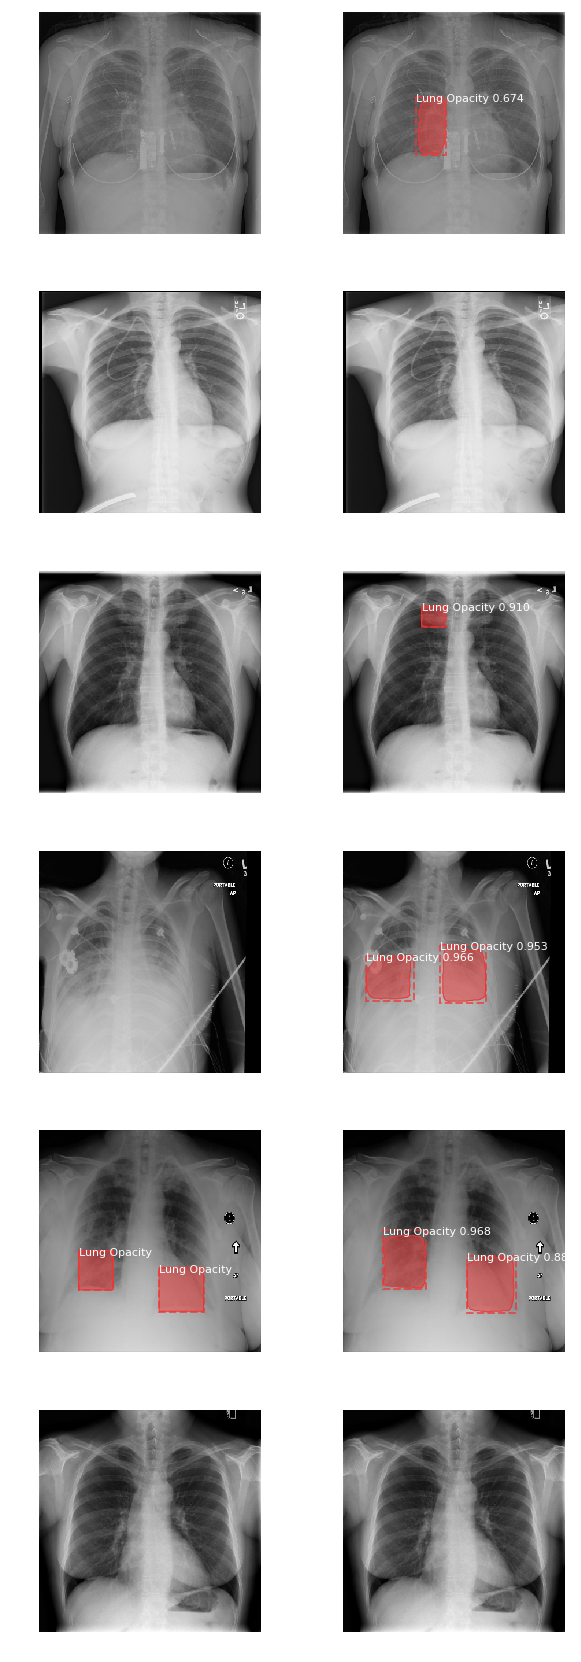

In [31]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))
iou_scores = []

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model_inf.detect([original_image])
    r = results[0]
    
    if len(r['rois']) or len(gt_bbox):
        iou = calc_iou_better(gt_bbox, r['rois'], 384)
        iou_scores.append(iou)
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    
print("Mean IOU:", np.mean(iou_scores))   

In [39]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [40]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model_inf.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [41]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [10:02<00:00,  4.98it/s]

/home/eric/pneumonia/working/submission.csv


In [42]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f {submission_fp} -m "mask-rcnn GCP 384x384 st 2 10 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [43]:
del(model_inf)

In [ ]:
# show a few test image detection example
def visualize2(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize2()
visualize2()
visualize2()
visualize2()